In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache
import psytrack as psy
import os

sns.set_style('ticks')

import src_local.utils as utils
import src_local.get_metrics as get_metrics
import src_local.format_Xy as format_Xy
import src_local.psy_funcs as psy_funcs

In [3]:
drive_dir = "/Volumes/Brain2024"
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=drive_dir, use_static_cache=True)

behavior_sessions = cache.get_behavior_session_table()

In [4]:
behavior_sessions.session_type.unique()

array(['HABITUATION_5_images_G_handoff_ready_5uL_reward',
       'TRAINING_1_gratings', 'TRAINING_2_gratings_flashed',
       'TRAINING_5_images_G_epilogue', 'TRAINING_3_images_G_10uL_reward',
       'TRAINING_4_images_G_training',
       'TRAINING_0_gratings_autorewards_15min',
       'HABITUATION_5_images_G_handoff_ready_3uL_reward',
       'TRAINING_5_images_G_handoff_ready_5uL_reward',
       'TRAINING_4_images_G_training_7uL_reward',
       'TRAINING_2_gratings_flashed_10uL_reward',
       'TRAINING_1_gratings_10uL_reward',
       'TRAINING_0_gratings_autorewards_15min_0uL_reward',
       'TRAINING_5_images_G_epilogue_5uL_reward',
       'EPHYS_1_images_G_3uL_reward',
       'TRAINING_5_images_G_handoff_lapsed_5uL_reward',
       'EPHYS_1_images_H_3uL_reward',
       'HABITUATION_5_images_H_handoff_ready_5uL_reward',
       'HABITUATION_5_images_H_handoff_ready_3uL_reward',
       'TRAINING_5_images_H_handoff_ready_5uL_reward',
       'TRAINING_3_images_H_10uL_reward',
       'TRA

In [11]:
subset_sessions = behavior_sessions[
    (behavior_sessions.session_type.str.contains('HABITUATION')) & 
    (behavior_sessions.session_type.str.contains('3uL_reward')) & 
    (behavior_sessions.genotype == 'wt/wt')]

# subset_sessions = behavior_sessions[
#     (behavior_sessions.session_type.str.contains('TRAINING_3')) & 
#     # (behavior_sessions.session_type.str.contains('handoff_ready')) & 
#     (behavior_sessions.genotype == 'wt/wt')]

# subset_sessions = behavior_sessions[
#     (behavior_sessions.session_type.str.contains('TRAINING_5')) & 
#     (behavior_sessions.session_type.str.contains('epilogue')) & 
#     (behavior_sessions.genotype == 'wt/wt')]

# subset_sessions = behavior_sessions[
#     (behavior_sessions.session_type.str.contains('TRAINING_5')) & 
#     (behavior_sessions.session_type.str.contains('handoff_lapse')) & 
#     (behavior_sessions.genotype == 'wt/wt')]


In [12]:
subset_sessions.session_type.unique()

array(['HABITUATION_5_images_G_handoff_ready_3uL_reward',
       'HABITUATION_5_images_H_handoff_ready_3uL_reward'], dtype=object)

In [13]:
len(subset_sessions)

155

In [14]:
session_df = pd.DataFrame(columns = ['auc', 'evd', 'visual_index', 'timing_index' ,'strategy_index'])

In [16]:
# np.where(subset_sessions.index.to_numpy() == bsid)[0][0] # this is Training 4
np.where(subset_sessions.index.to_numpy() == 1066084388)[0][0]


59

#### singular :
singular_bsid = 1062558420 # skipped, 4

singular_bsid = 1064649114, 1099179626 # skipped, 5




 Processing 1066084388


/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/swdb2024/lib/python3.9/site-packages/allensdk/brain_observatory/behavior/data_objects/metadata/subject_metadata/full_genotype.py:57: UserWarning: Unable to parse cre_line from full_genotype
  warnings.warn('Unable to parse cre_line from full_genotype')
/Users/xinzheng/Repos/swdb_2024_project/src_local/format_Xy.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


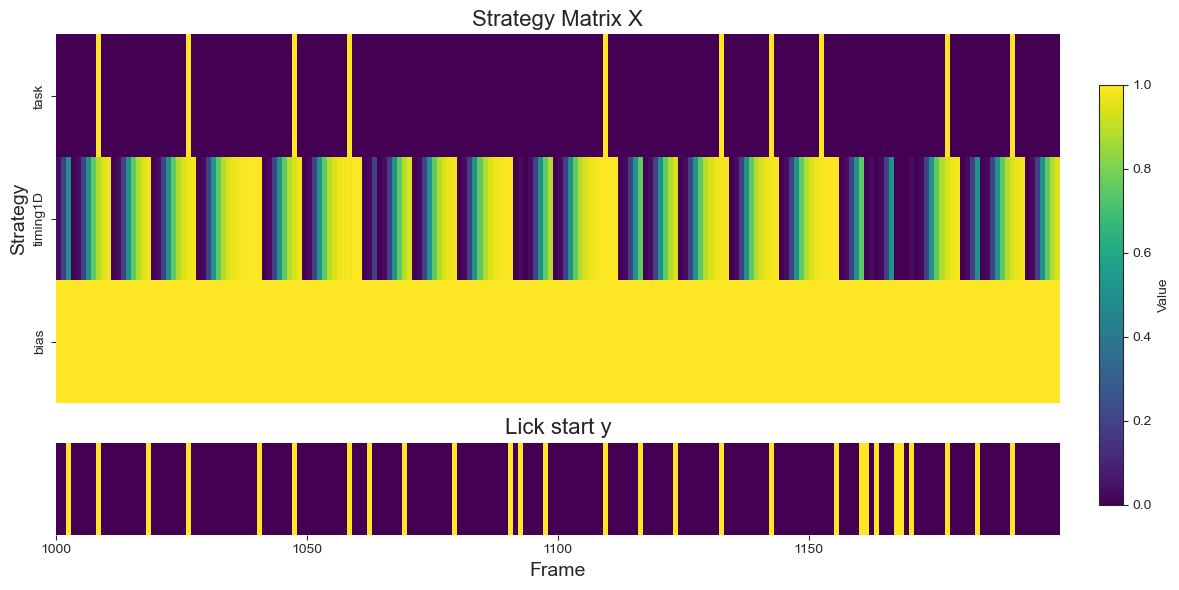

{'task': 1, 'timing1D': 1, 'bias': 1}
Model Evidence: -1136.7789842371349
Cross Validation Analysis
running fold 0

In [17]:
sessions_with_err = []

for i, bsid in enumerate(subset_sessions.index[59:]):

    print(f'\n Processing {bsid}')

    dir = f'local_modelfit/habituation2/{bsid}'
    os.makedirs(dir, exist_ok=True)

    plot_dir = f'plots/modelfit/habituation2/{bsid}'
    os.makedirs(plot_dir, exist_ok=True)

    try:

        behavior_session = cache.get_behavior_session(bsid)
        licks = behavior_session.licks
        licks_annot = get_metrics.annotate_licks(licks, behavior_session)
        stimulus_presentations = behavior_session.stimulus_presentations
        stimulus_presentations = stimulus_presentations[stimulus_presentations['active']]
        stim_table = get_metrics.annotate_bouts(licks_annot, stimulus_presentations)

        format_options = {
                        'preprocess': 2, 
                        'timing_params': [-5,4],
                        'num_cv_folds': 10}

        psydata = format_Xy.build_regressor(stim_table, format_options, behavior_session)

        strategy_list = ['task', 'timing1D', 'bias']


        format_Xy.visualize_design(psydata['full_df'], strategy_list, f'{plot_dir}/weight_mat', t_start = 1000)

        # # this is for other non-recording sessions // But handled already ! I think !
        # if np.sum(stimulus_presentations.omitted) == 0:
        #     strategy_list.remove('omissions')
        #     strategy_list.remove('omissions1')
        hyp, evd, wMode, credibleInt,weights = psy_funcs.fit_weights(psydata,strategy_list)
        # Save to .npy file
        np.save(f'{dir}/wMode.npy', wMode)
        ypred,ypred_each = psy_funcs.compute_ypred(psydata, wMode,weights)
        psy_funcs.plot_weights(wMode, weights,psydata,errorbar=credibleInt, ypred=ypred,
            filename=f"{plot_dir}/fit")
        print('Model Evidence:', evd)

        print("Cross Validation Analysis")
        cross_psydata = psy.trim(psydata, 
        END=int(np.floor(len(psydata['y'])/format_options['num_cv_folds'])\
        *format_options['num_cv_folds'])) 
        cross_results = psy_funcs.compute_cross_validation(cross_psydata, hyp, weights,
        folds=format_options['num_cv_folds'])
        cv_pred = psy_funcs.compute_cross_validation_ypred(cross_psydata, cross_results,ypred)
        auc = psy_funcs.compute_model_roc(psydata['y'],cv_pred,plot_this=True)

        print("Lesion Analysis")
        minus_task = strategy_list.copy()
        minus_task.remove('task')
        _, evd_minus_task, _, _, _ = psy_funcs.fit_weights(psydata,minus_task)
        minus_timing =  [s for s in strategy_list if 'timing' not in s]
        _, evd_minus_timing, _, _, _ = psy_funcs.fit_weights(psydata,minus_timing)
        # Calculate indices
        visual_index = utils.calculate_index(evd, evd_minus_task)
        timing_index = utils.calculate_index(evd, evd_minus_timing)
        # Calculate overall strategy index
        strategy_index = visual_index - timing_index

        print(f"Visual Index: {visual_index:.2f}%")
        print(f"Timing Index: {timing_index:.2f}%")
        print(f"Overall Strategy Index: {strategy_index:.2f}")

        # Determine dominant strategy
        dominant_strategy = "Visual" if strategy_index > 0 else "Timing"
        print(f"Dominant Strategy: {dominant_strategy}")

        # Create a new row with the calculated values
        new_row = pd.DataFrame({
            'auc': [auc],
            'evd': [evd],
            'visual_index': [visual_index],
            'timing_index': [timing_index],
            'strategy_index': [strategy_index]
        }, index=[bsid])

        # Append the new row to session_df
        session_df = pd.concat([session_df, new_row])

    except RuntimeError as e:
        print(f"Error processing {bsid}: {str(e)}")
        sessions_with_err.append(bsid)
        continue  # Skip to the next sample

# After the loop, you can print out which samples had errors
print("Samples that encountered errors:", sessions_with_err)

session_df.to_csv('local_modelfit/habituation2/strategy_summary.csv')

In [ ]:
print('Sessions that has error:\n', sessions_with_err)

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=session_df.visual_index, 
                     y=session_df.timing_index, 
                     c=session_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Visual Index', fontsize=14)
ax.set_ylabel('Timing Index', fontsize=14)
ax.set_title('Visual vs Timing Index', fontsize=16)

max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([max_val, 0], [0, max_val], 'k--', alpha=0.8)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
